## sigMF RF classification; 12 classes

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob
import json
from os import walk
import pickle
import json
import pathlib
import random
from timeit import default_timer as timer
import time
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
global GPU, fft, Fs, center_freq, fft_val, Fs_test, loss, batches, eps, var_noise, mean_noise, top
global c1_coeff, c2_coeff, a, r1_c1, r2_c1, r1_c2, r2_c2, compare
a = 1
r1_c2 = 1
r2_c2 = 10e1
top = .99
var_noise = 8.78e-09
mean_noise = 1 # not used
eps = 1e-15
Fs = 1000000
fft = 1024
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz
center_freq_live = 428.00e6 # when SDR doing 25MSPS with center at 428MHz
batches = 64
plt.style.use('default')
GPU = 0
device = torch.device('cuda:0')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:0
Is cuda available? = True


In [2]:
r2_c2

100.0

In [3]:
!. /home/david/prefix-3.8/setup_env.sh

#### Machine paths

In [4]:
path_ram = "/home/david/sigMF_ML/RF/ramdisk/"
path_usrp = "/home/david/prefix-3.8/"
path = "/home/david/sigMF_ML/RF/RF_class/data/" # ACE
path_val1 = "/home/david/sigMF_ML/RF/RF_class/data_val1/" # fft_center    - class 9
path_val2 = "/home/david/sigMF_ML/RF/RF_class/data_val2/" # light switch - class 10
path_val3 = "/home/david/sigMF_ML/RF/RF_class/data_val3/" # clickndig     - class 5
path_val4 = "/home/david/sigMF_ML/RF/RF_class/data_val4/" # GD55          - class 1
path_val5 = "/home/david/sigMF_ML/RF/RF_class/data_val5/" # lora125       - class 0
path_val6 = "/home/david/sigMF_ML/RF/RF_class/data_val6/" # lora250       - class 7
path_val7 = "/home/david/sigMF_ML/RF/RF_class/data_val7/" # NFM           - class 2
path_val8 = "/home/david/sigMF_ML/RF/RF_class/data_val8/" # sado          - class 6
path_val9 = "/home/david/sigMF_ML/RF/RF_class/data_val9/" # TYT           - class 3
path_val10 = "/home/david/sigMF_ML/RF/RF_class/data_val10/" # vodeson     - class 4
path_val11 = "/home/david/sigMF_ML/RF/RF_class/data_val11/" # white noise - class 8
path_val12 = "/home/david/sigMF_ML/RF/RF_class/data_val12/" # ysf        - class 11
path_fig = "/home/david/sigMF_ML/RF/RF_class/" # ACE
path_val = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_save = "/home/david/sigMF_ML/RF/RF_class/saved/" # ACE
path_test = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_test_1msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/" # ACE
path_test_5msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_5msps/" # ACE
path_test_10msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_10msps/" # ACE
path_test_25msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_25msps/" # ACE
print(path)

/home/david/sigMF_ML/RF/RF_class/data/


## Functions 

In [5]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def save_model(epoch,loss):
    rf_model = 'VGG16_20210309_2D_1e5'
    PATH = path_save+rf_model
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,}, PATH)   
    
def load_model():
    rf_model = 'VGG16_v58_20210211_2D_10dB_noise_autosave'
    PATH = path_save+rf_model
    device = torch.device("cuda:1")
    model = resnet50(2, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()     

def gpu_test_file(db):
    if (msps == 1):
        w1 = fft
    elif (msps == 5):
        w1 = fft*1
    elif (msps == 10):
        w1 = fft*1        
    elif (msps == 25):
        w1 = fft*1 
    print('gpu_test file function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    print('window length = ', w1)
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=fft, hop_length=fft//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=fft, hop_length=fft//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    I_mag = torch.abs(torch.sqrt(I_stft[:,:,0]**2+I_stft[:,:,1]**2))
    Q_mag = torch.abs(torch.sqrt(Q_stft[:,:,0]**2+Q_stft[:,:,1]**2))     
    I_mag = torch.unsqueeze(I_mag, dim=2)
    Q_mag = torch.unsqueeze(Q_mag, dim=2)   
#     print('I shape =', I_stft.shape, 'Q shape = ', Q_stft.shape )
#     print('I_mag shape =', I_mag.shape, 'Q_mag shape = ', Q_mag.shape )
    Z_stft = torch.cat((I_mag,Q_mag),2)
#     Z_stft = torch.cat((Z_stft[fft//2:,:,:],Z_stft[:fft//2,:,:])) # NOT SURE I NEED TO DO THIS...
#     print('gpu_test file Z shape =', Z_stft.shape)
    Z_stft = Z_stft[fft//2:,:,:] # throw bottom 1/2 away
    print('FINAL gpu_test FILE IQ shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 2D

def gpu_test_live(db,msps):
    if (msps == 1):
        w1 = fft
    elif (msps == 5):
        w1 = fft*1
    elif (msps == 10):
        w1 = fft*1        
    elif (msps == 25):
        w1 = fft*1     
    print('gpu_test live function')    
#     I = db[0:10000000:2]
#     Q = db[1:10000000:2]    
    I = db[0::2]
    Q = db[1::2]
    print('I length = ', len(I))
    print('Q length = ', len(Q))
    w = fft*msps
    print(w,'MSPS')
    den = 2
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    I_mag = torch.abs(torch.sqrt(I_stft[:,:,0]**2+I_stft[:,:,1]**2))
    Q_mag = torch.abs(torch.sqrt(Q_stft[:,:,0]**2+Q_stft[:,:,1]**2))      
    I_mag = torch.unsqueeze(I_mag, dim=2)
    Q_mag = torch.unsqueeze(Q_mag, dim=2)  
    Z_stft = torch.cat((I_mag,Q_mag),2)
    print('gpu_test live IQ shape =', Z_stft.shape)
#     Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    Z_stft = Z_stft[:w//2,:,:]# throw bottom 1/2 away
    print('FINAL gpu_test LIVE IQ shape =', Z_stft.shape)
    return Z_stft # Returning 2D and plot
   
def iq_read(data_files): # USING GPU to perform STFT
    print('iq_read function**********')
    data_IQ_list = []
    data_IQ_temp = []
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
#         stft = gpu(db).detach().cpu().numpy()
        print('iq_read function')
        stft, stft_plot = gpu_test_file(db)
        stft = stft.detach().cpu().numpy()
        stft_plot = stft_plot.detach().cpu().numpy()
        stft_plot = 10*np.log10(np.abs(stft_plot+eps))
        plt.imshow(stft_plot)
        plt.pcolormesh(stft_plot)
#         plt.imshow(stft, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft)
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_file(data_files): # USING GPU to perform STFT
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test file')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db)
        stft_plot = 20*np.log10(np.abs(stft[:,:,0].detach().cpu().numpy()+eps))
        print('imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list


def iq_read_test_live(data_files,msps): # USING GPU to perform STFT
#     iq_cpu_plot(data_files) #checking with cpu complex plotting
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test live')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_live(db,msps)
        # *************************************************************************
#         stft_plot = 20*np.log10(np.abs(stft[:,:,0].detach().cpu().numpy()+eps))
#         print('iq_read_test live imshow method')
#         plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
#         plt.show()
        # *************************************************************************
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list


def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

#**************************** Print historgram subplots ******************************
def histo_plots(inputs):
    fig=plt.figure(figsize=(8,8))
    ncols = 2
    nrows = 2
    print('make torch inputs')
    print('inputs shape for histogram1 = ', inputs.shape)
    inputs = 10*np.log10(np.abs(inputs.cpu()+eps))
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('type = ', type(flat_inputs))
#         print('x = ', x, 'flat_input max = ', np.amax(flat_inputs))
#         print('inputs are: ', flat_inputs.shape)
        fig.add_subplot(nrows, ncols, x+1)
        plt.hist(flat_inputs, bins=5000)
        plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
        plt.xlim(-100, 10)
#         plt.ylim(0, 40000)
    return flat_inputs
#*************************************************************************************    
#**************************** Print historgram subplots ******************************
def histo_stats(inputs):
#     print('make torch inputs')
#     print('inputs shape for histogram1 = ', inputs.shape)
    mean = np.zeros(4)
    std = np.zeros(4)
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('inputs are: ', flat_inputs.shape)
        mean[x] = flat_inputs.mean()
        std[x] = flat_inputs.std()
#         print('mean = ', mean, 'std = ', std)
    return mean, std
#**************************** Print historgram freq stats ******************************
def histo_stats_freq_file(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')         
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')        
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
def histo_stats_freq_live(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')          
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')         
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
# END OF FUNCTIONS ******************************************************

In [6]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [7]:
VGG_types = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG_net(nn.Module):
    def __init__(self, in_channels=2, num_classes=12):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types['VGG16'])
        
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
            )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == int:
                out_channels = x
                
                layers += [nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
                
        return nn.Sequential(*layers)

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = VGG_net(in_channels=2,num_classes=12).to(device)
    print(model)
    ## N = 3 (Mini batch size)
    #x = torch.randn(3, 3, 224, 224).to(device)
    #print(model(x).shape)

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [8]:
from torchsummary import summary

# model = VGG_net()
# summary(model.cuda(), (2, 224, 224))

In [9]:
from torch.utils.data import Dataset

In [10]:
class RFDataset(Dataset):
    def __init__(self, root_path):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7]
        label = self.get_class[foldername]

        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': label}

#### Evaluation dataset loader

In [11]:
rf_dataset1 = RFDataset(path_val1)
val1_data = data.DataLoader(rf_dataset1, batch_size=batches, shuffle=True)
rf_dataset2 = RFDataset(path_val2)
val2_data = data.DataLoader(rf_dataset2, batch_size=batches, shuffle=True)
rf_dataset3 = RFDataset(path_val3)
val3_data = data.DataLoader(rf_dataset3, batch_size=batches, shuffle=True)
rf_dataset4 = RFDataset(path_val4)
val4_data = data.DataLoader(rf_dataset4, batch_size=batches, shuffle=True)
rf_dataset5 = RFDataset(path_val5)
val5_data = data.DataLoader(rf_dataset5, batch_size=batches, shuffle=True)
rf_dataset6 = RFDataset(path_val6)
val6_data = data.DataLoader(rf_dataset6, batch_size=batches, shuffle=True)
rf_dataset7 = RFDataset(path_val7)
val7_data = data.DataLoader(rf_dataset7, batch_size=batches, shuffle=True)
rf_dataset8 = RFDataset(path_val8)
val8_data = data.DataLoader(rf_dataset8, batch_size=batches, shuffle=True)
rf_dataset9 = RFDataset(path_val9)
val9_data = data.DataLoader(rf_dataset9, batch_size=batches, shuffle=True)
rf_dataset10 = RFDataset(path_val10)
val10_data = data.DataLoader(rf_dataset10, batch_size=batches, shuffle=True)
rf_dataset11 = RFDataset(path_val11)
val11_data = data.DataLoader(rf_dataset11, batch_size=batches, shuffle=True)
rf_dataset12 = RFDataset(path_val12)
val12_data = data.DataLoader(rf_dataset12, batch_size=batches, shuffle=True)

/home/david/sigMF_ML/RF/RF_class/data_val1/
/home/david/sigMF_ML/RF/RF_class/data_val2/
/home/david/sigMF_ML/RF/RF_class/data_val3/
/home/david/sigMF_ML/RF/RF_class/data_val4/
/home/david/sigMF_ML/RF/RF_class/data_val5/
/home/david/sigMF_ML/RF/RF_class/data_val6/
/home/david/sigMF_ML/RF/RF_class/data_val7/
/home/david/sigMF_ML/RF/RF_class/data_val8/
/home/david/sigMF_ML/RF/RF_class/data_val9/
/home/david/sigMF_ML/RF/RF_class/data_val10/
/home/david/sigMF_ML/RF/RF_class/data_val11/
/home/david/sigMF_ML/RF/RF_class/data_val12/


#### list of loaders

In [12]:
val_data_list = [val1_data]
val_data_list.append(val2_data)
val_data_list.append(val3_data)
val_data_list.append(val4_data)
val_data_list.append(val5_data)
val_data_list.append(val6_data)
val_data_list.append(val7_data)
val_data_list.append(val8_data)
val_data_list.append(val9_data)
val_data_list.append(val10_data)
val_data_list.append(val11_data)
val_data_list.append(val12_data)
print('done')

done


## Training

In [13]:
def train_net(total):
    test_patch_total = 24000 # 120000
    compare = .7
    loss_plot = np.zeros(total)
    total_plot = np.zeros(total//5+1)
    batch_plot = np.zeros(len(training_data)*total//100)
    batch_indexer = 0
    for epoch in tqdm(range(total), desc="Epoch"): 
        model.train()
        start = timer()
        for i, rf_data in enumerate(training_data, 0):
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
#             print('input1  = ', inputs.shape)
            inputs = inputs.permute(0,3,1,2).contiguous()
#             print('input before noise add  = ', inputs.shape)
            batch_dim, b, c, d = inputs.shape
            # add som noise
            c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            inputs = inputs + torch.abs((((var_noise*c2)**0.5)*torch.randn(batch_dim, 4, 224, 224)*1))  
            #**************** take I and Q magnitudue only ***********
            I_temp = torch.abs(torch.sqrt(inputs[:,0,:,:]**2+inputs[:,1,:,:]**2))        
            I_temp = torch.unsqueeze(I_temp, dim=1)
            Q_temp = torch.abs(torch.sqrt(inputs[:,2,:,:]**2+inputs[:,3,:,:]**2))
            Q_temp = torch.unsqueeze(Q_temp, dim=1)
            inputs = torch.cat((I_temp,Q_temp),1)
#             print('inputs after noise add  = ', inputs.shape) 
            #*********************************************************  
#             batch_dim, b, c, d = inputs.shape
#             # add som noise
#             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
#             inputs = inputs + torch.abs((((var_noise*c2)**0.5)*torch.randn(batch_dim, 2, 224, 224)*1))  
            inputs = Variable(inputs.cuda(GPU))
            labels = rf_data['label']
            labels = labels.cuda(GPU)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        end = timer()
        batch_time = end - start
        #***************************************************************************************
        print('batch time = ', batch_time)
        print('************************* start *************************')
        total_correct_patches = grand_total = 0
        start_test = timer()
        model.eval()
        for testing in val_data_list:
            t = train_val(testing)
            total_correct_patches = total_correct_patches + t           
        grand_total = total_correct_patches/test_patch_total
        batch_plot[batch_indexer] = grand_total*100
        batch_indexer = batch_indexer + 1
    #     print('Batch number = ', i, 'of', len(training_data))
        print('Total % correct {:.2f}%'.format(grand_total*100))         
        model.train 
        end_test = timer()
        test_time = end_test - start_test
        print('test time = ', test_time)
        print('*************************** end ***************************')
        #****************************************************************************************         
        save_model(epoch,loss)
        tqdm.write('___________________________________________')
        tqdm.write("Epoch {} Loss {:.10f} ".format(epoch+1, loss.data*1)) 
        tqdm.write('___________________________________________')        
    return loss_plot, batch_plot

#### Training Evaluation

In [14]:
def train_val(val_data):
    with torch.no_grad():
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        for i, rf_data in enumerate(val_data, 0): 
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous() 
            batch_dim, b, c, d = inputs.shape
            # add som noise
            c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            inputs = inputs + torch.abs((((var_noise*c2)**0.5)*torch.randn(batch_dim, 4, 224, 224)*1))              
            #**************** take I and Q magnitudue only ***********
            I_temp = torch.abs(torch.sqrt(inputs[:,0,:,:]**2+inputs[:,1,:,:]**2))
            I_temp = torch.unsqueeze(I_temp, dim=1)
            Q_temp = torch.abs(torch.sqrt(inputs[:,2,:,:]**2+inputs[:,3,:,:]**2))
            Q_temp = torch.unsqueeze(Q_temp, dim=1)
            inputs = torch.cat((I_temp,Q_temp),1)
            #*********************************************************               
#             batch_dim, b, c, d = inputs.shape
#             # add som noise
#             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
#             inputs = inputs + torch.abs((((var_noise*c2)**0.5)*torch.randn(batch_dim, 2, 224, 224)*1))  
            inputs = Variable(inputs.cuda(GPU))
            labels = rf_data['label']
            labels = labels.cuda(GPU)
            optimizer.zero_grad() 
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) 
            for b in range(len(predicted)):
                labels_temp = labels[b].detach().cpu().numpy()
                temp = predicted[b].detach().cpu().numpy()
                if (labels_temp==temp):
                    accumulated_corrects = accumulated_corrects+1
    torch.cuda.empty_cache()
    return accumulated_corrects

## Inference Segmented Dataloader

In [15]:
# Inference Dataloader with labels
class inference_dataloader_segmented_live(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # use only 1 for semi-live inferencing
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

In [16]:
# Inference Dataloader with labels
class inference_dataloader_segmented(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

### validation functions

In [17]:
def validation_read():    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("validation file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read(data_files_validation)
    return data_IQ_list_val, meta_list_val

In [18]:
def testing_read():
    print('testing_read function')
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("testing file name = ", meta)
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation)
    return data_IQ_list_val, meta_list_val

#### Changed to get test data from different directory

In [19]:
def inference_read(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_live(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [20]:
def inference_read_file(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_live(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [21]:
    # inference ************************************************************
def testing_file(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
        start_frequency = (center_freq_file)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
#         total = 68
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
#**************************** Print segmented pics ***********************************
#                 stft_plot = np.squeeze(inputs, axis=0)
#                 fig=plt.figure(figsize=(8,8))
#                 ncols = 5
#                 nrows = 5
#                 range_plot = 1
#                 for x in range(1,22): # need to figure out how to not hard code this ********************* <-----
#                     stft_mean, stft_std = histo_stats(stft_plot[x,:,:,:])
#                     if (x>=range_plot and x<(range_plot+25)):
#                         stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
#                         stft_plot1 = np.squeeze(stft_plot1, axis=0)
#                         fig.add_subplot(nrows, ncols, x-range_plot+1)
#                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                 plt.show()
#******************************************************************************************    
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
                print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
                print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
                print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
                print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_plot+25)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_file(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [22]:
    # inference ************************************************************
def testing_live(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
        start_frequency = (center_freq_live)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
                print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
                stft_plot = np.squeeze(inputs, axis=0)
                fig=plt.figure(figsize=(8,8))
                ncols = 5
                nrows = 5
                range_plot = 1
                range_end = range_plot+5
                for x in range(1,51): # need to figure out how to not hard code this ********************* <-----
                    if (x>=range_plot and x<(range_end)):
                        stft_plot1 =  stft_plot[x, :, :, 1]
                        stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
                        fig.add_subplot(nrows, ncols, x-range_plot+1)
                        plt.imshow(stft_plot1, vmin=-70, vmax=5)
                plt.show()
#******************************************************************************************    
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
                print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
                print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
                print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
                print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_end)):                    
# #                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#                         print('******************')
#*************************************************************************************              
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_live(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [23]:
train_dataloader = RFDataset(path)

/home/david/sigMF_ML/RF/RF_class/data/


In [24]:
training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

## CUDA initialization

In [25]:
model = VGG_net()
CUDA = torch.cuda.is_available()
if CUDA:
    model.cuda(GPU)
CUDA  

True

In [26]:
torch.cuda.empty_cache()

## Final training initialization

In [27]:
# momentum = .3
criterion = nn.CrossEntropyLoss()
lr= 1e-5
optimizer = optim.AdamW(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr,momentum=momentum)
# optimizer = optim.RMSprop(model.parameters(), lr=lr,momentum=momentum)
# optimizer = optim.SGD(model.parameters(), lr=lr)
# training_data = data.DataLoader(rf_dataset, batch_size=batches, shuffle=True)
model.train()

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [28]:
# VALIDATION ************************************************************
np.set_printoptions(threshold=np.inf)
calc = np.zeros([6])
averaging = 0
correct = 0
total = 0
V = data.DataLoader(inference_dataloader_segmented(), batch_size=1, shuffle=True)
model.eval()

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

### TRAIN Model

In [29]:
total = 100
loss_plot,total_plot = train_net(total)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

batch time =  1114.1111512719654
************************* start *************************
Total % correct 90.77%
test time =  125.77314631501213
*************************** end ***************************


Epoch:   1%|          | 1/100 [20:43<34:12:19, 1243.83s/it]

___________________________________________
Epoch 1 Loss 0.0003002537 
___________________________________________
batch time =  1106.320772982901
************************* start *************************
Total % correct 95.38%
test time =  126.01077904400881
*************************** end ***************************


Epoch:   2%|▏         | 2/100 [41:20<33:48:14, 1241.78s/it]

___________________________________________
Epoch 2 Loss 0.0048153657 
___________________________________________
batch time =  1107.456508897012
************************* start *************************
Total % correct 82.55%
test time =  126.07676635100506
*************************** end ***************************


Epoch:   3%|▎         | 3/100 [1:01:58<33:25:44, 1240.67s/it]

___________________________________________
Epoch 3 Loss 0.0002364961 
___________________________________________
batch time =  1106.3451444430975
************************* start *************************
Total % correct 99.05%
test time =  127.97770511102863
*************************** end ***************************


Epoch:   4%|▍         | 4/100 [1:22:37<33:04:12, 1240.13s/it]

___________________________________________
Epoch 4 Loss 0.0059131170 
___________________________________________
batch time =  1108.080291841994
************************* start *************************
Total % correct 88.75%
test time =  126.15649091498926
*************************** end ***************************


Epoch:   5%|▌         | 5/100 [1:43:16<32:42:55, 1239.74s/it]

___________________________________________
Epoch 5 Loss 0.0033448641 
___________________________________________
batch time =  1107.5963382149348
************************* start *************************
Total % correct 91.33%
test time =  125.72457941900939
*************************** end ***************************


Epoch:   6%|▌         | 6/100 [2:03:54<32:21:21, 1239.17s/it]

___________________________________________
Epoch 6 Loss 0.0008757513 
___________________________________________
batch time =  1107.204206796945
************************* start *************************
Total % correct 96.83%
test time =  125.27529616910033
*************************** end ***************************


Epoch:   7%|▋         | 7/100 [2:24:31<31:59:43, 1238.53s/it]

___________________________________________
Epoch 7 Loss 0.1627686918 
___________________________________________
batch time =  1107.7805062900297
************************* start *************************
Total % correct 95.65%
test time =  132.35767092101742
*************************** end ***************************


Epoch:   8%|▊         | 8/100 [2:45:16<31:41:57, 1240.41s/it]

___________________________________________
Epoch 8 Loss 0.0001295263 
___________________________________________
batch time =  1107.6162084850948
************************* start *************************
Total % correct 94.70%
test time =  133.18435841600876
*************************** end ***************************


Epoch:   9%|▉         | 9/100 [3:06:01<31:23:38, 1241.97s/it]

___________________________________________
Epoch 9 Loss 0.0003669492 
___________________________________________
batch time =  1107.3229093489936
************************* start *************************
Total % correct 97.92%
test time =  125.13457606604788
*************************** end ***************************


Epoch:  10%|█         | 10/100 [3:26:38<31:00:41, 1240.46s/it]

___________________________________________
Epoch 10 Loss 0.0008735129 
___________________________________________
batch time =  1108.4758516850416
************************* start *************************
Total % correct 94.60%
test time =  125.96590073406696
*************************** end ***************************


Epoch:  11%|█         | 11/100 [3:47:17<30:39:20, 1240.01s/it]

___________________________________________
Epoch 11 Loss 0.0014461512 
___________________________________________
batch time =  1108.6819613219704
************************* start *************************
Total % correct 87.10%
test time =  125.86779741500504
*************************** end ***************************


Epoch:  12%|█▏        | 12/100 [4:07:56<30:18:15, 1239.73s/it]

___________________________________________
Epoch 12 Loss 0.0000905897 
___________________________________________
batch time =  1130.105481567909
************************* start *************************
Total % correct 85.71%
test time =  125.27778859296814
*************************** end ***************************


Epoch:  13%|█▎        | 13/100 [4:28:56<30:06:24, 1245.80s/it]

___________________________________________
Epoch 13 Loss 0.0004796609 
___________________________________________
batch time =  1104.4514194300864
************************* start *************************
Total % correct 78.07%
test time =  125.9991155519383
*************************** end ***************************


Epoch:  14%|█▍        | 14/100 [4:49:31<29:40:59, 1242.55s/it]

___________________________________________
Epoch 14 Loss 0.0009798552 
___________________________________________
batch time =  1127.9961698750267
************************* start *************************
Total % correct 95.57%
test time =  126.82122189702932
*************************** end ***************************


Epoch:  15%|█▌        | 15/100 [5:10:31<29:27:25, 1247.59s/it]

___________________________________________
Epoch 15 Loss 0.0005360670 
___________________________________________
batch time =  1103.2679648360936
************************* start *************************
Total % correct 99.95%
test time =  125.66430370800663
*************************** end ***************************


Epoch:  16%|█▌        | 16/100 [5:31:04<29:00:43, 1243.38s/it]

___________________________________________
Epoch 16 Loss 0.0010819607 
___________________________________________
batch time =  1103.5062741260044
************************* start *************************
Total % correct 99.74%
test time =  129.16208281891886
*************************** end ***************************


Epoch:  17%|█▋        | 17/100 [5:51:41<28:37:27, 1241.53s/it]

___________________________________________
Epoch 17 Loss 0.0008378274 
___________________________________________
batch time =  1103.0334696890786
************************* start *************************
Total % correct 92.27%
test time =  128.6715936330147
*************************** end ***************************


Epoch:  18%|█▊        | 18/100 [6:12:18<28:14:36, 1239.96s/it]

___________________________________________
Epoch 18 Loss 0.0002638938 
___________________________________________
batch time =  1106.5505954290275
************************* start *************************
Total % correct 78.47%
test time =  126.11705152899958
*************************** end ***************************


Epoch:  19%|█▉        | 19/100 [6:32:55<27:52:48, 1239.12s/it]

___________________________________________
Epoch 19 Loss 0.6696496010 
___________________________________________
batch time =  1107.2182827880606
************************* start *************************
Total % correct 85.96%
test time =  125.10566720704082
*************************** end ***************************


Epoch:  20%|██        | 20/100 [6:53:32<27:31:16, 1238.45s/it]

___________________________________________
Epoch 20 Loss 0.0002829172 
___________________________________________
batch time =  1107.5880443870556
************************* start *************************
Total % correct 88.26%
test time =  124.73302131693345
*************************** end ***************************


Epoch:  21%|██        | 21/100 [7:14:09<27:09:59, 1237.97s/it]

___________________________________________
Epoch 21 Loss 0.0000001714 
___________________________________________
batch time =  1109.3871320229955
************************* start *************************
Total % correct 95.43%
test time =  129.39210927009117
*************************** end ***************************


Epoch:  22%|██▏       | 22/100 [7:34:52<26:51:27, 1239.59s/it]

___________________________________________
Epoch 22 Loss 0.0009318141 
___________________________________________
batch time =  1110.560001431033
************************* start *************************
Total % correct 82.88%
test time =  126.03952819795813
*************************** end ***************************


Epoch:  23%|██▎       | 23/100 [7:55:33<26:31:24, 1240.06s/it]

___________________________________________
Epoch 23 Loss 0.0569526777 
___________________________________________
batch time =  1108.731621881947
************************* start *************************
Total % correct 83.00%
test time =  125.16192544205114
*************************** end ***************************


Epoch:  24%|██▍       | 24/100 [8:16:12<26:10:07, 1239.58s/it]

___________________________________________
Epoch 24 Loss 0.0004207559 
___________________________________________
batch time =  1111.0165139620658
************************* start *************************
Total % correct 93.38%
test time =  125.44900226499885
*************************** end ***************************


Epoch:  25%|██▌       | 25/100 [8:36:53<25:50:01, 1240.01s/it]

___________________________________________
Epoch 25 Loss 0.0004152502 
___________________________________________
batch time =  1108.5737635529367
************************* start *************************
Total % correct 99.55%
test time =  125.41592342301738
*************************** end ***************************


Epoch:  26%|██▌       | 26/100 [8:57:31<25:28:47, 1239.56s/it]

___________________________________________
Epoch 26 Loss 0.0018320703 
___________________________________________
batch time =  1109.040849752957
************************* start *************************
Total % correct 91.99%
test time =  126.1888304100139
*************************** end ***************************


Epoch:  27%|██▋       | 27/100 [9:18:11<25:08:13, 1239.64s/it]

___________________________________________
Epoch 27 Loss 0.0002275684 
___________________________________________
batch time =  1109.1697985080536
************************* start *************************
Total % correct 93.30%
test time =  125.36981280392502
*************************** end ***************************


Epoch:  28%|██▊       | 28/100 [9:38:50<24:47:23, 1239.49s/it]

___________________________________________
Epoch 28 Loss 0.0011327236 
___________________________________________
batch time =  1109.959583997028
************************* start *************************
Total % correct 98.75%
test time =  125.87658925307915
*************************** end ***************************


Epoch:  29%|██▉       | 29/100 [9:59:31<24:27:03, 1239.77s/it]

___________________________________________
Epoch 29 Loss 0.0021999213 
___________________________________________
batch time =  1108.974402675056
************************* start *************************
Total % correct 86.73%
test time =  125.39855393196922
*************************** end ***************************


Epoch:  30%|███       | 30/100 [10:20:10<24:06:08, 1239.55s/it]

___________________________________________
Epoch 30 Loss 0.0003583076 
___________________________________________
batch time =  1162.191817124025
************************* start *************************
Total % correct 98.36%
test time =  141.450208368944
*************************** end ***************************


Epoch:  31%|███       | 31/100 [10:41:58<24:09:12, 1260.18s/it]

___________________________________________
Epoch 31 Loss 0.0020389338 
___________________________________________
batch time =  1133.8189413029468
************************* start *************************
Total % correct 90.10%
test time =  125.34680631395895
*************************** end ***************************


Epoch:  32%|███▏      | 32/100 [11:03:02<23:49:25, 1261.25s/it]

___________________________________________
Epoch 32 Loss 0.0004077766 
___________________________________________
batch time =  1105.6304520670092
************************* start *************************
Total % correct 94.67%
test time =  125.22016190900467
*************************** end ***************************


Epoch:  33%|███▎      | 33/100 [11:23:37<23:19:44, 1253.50s/it]

___________________________________________
Epoch 33 Loss 0.0008689926 
___________________________________________
batch time =  1104.898483568919
************************* start *************************
Total % correct 93.41%
test time =  125.72320505301468
*************************** end ***************************


Epoch:  34%|███▍      | 34/100 [11:44:12<22:52:48, 1248.00s/it]

___________________________________________
Epoch 34 Loss 0.0006263592 
___________________________________________
batch time =  1104.7545517560793
************************* start *************************
Total % correct 99.84%
test time =  125.51923802902456
*************************** end ***************************


Epoch:  35%|███▌      | 35/100 [12:04:47<22:27:43, 1244.06s/it]

___________________________________________
Epoch 35 Loss 0.0001054228 
___________________________________________
batch time =  1104.5419984980254
************************* start *************************
Total % correct 99.85%
test time =  125.36550846800674
*************************** end ***************************


Epoch:  36%|███▌      | 36/100 [12:25:21<22:03:54, 1241.17s/it]

___________________________________________
Epoch 36 Loss 0.0005813206 
___________________________________________
batch time =  1103.677523522987
************************* start *************************
Total % correct 99.80%
test time =  125.17673139995895
*************************** end ***************************


Epoch:  37%|███▋      | 37/100 [12:45:55<21:40:49, 1238.88s/it]

___________________________________________
Epoch 37 Loss 0.0019490073 
___________________________________________
batch time =  1102.8599827750586
************************* start *************************
Total % correct 99.75%
test time =  125.54226774501149
*************************** end ***************************


Epoch:  38%|███▊      | 38/100 [13:06:28<21:18:20, 1237.10s/it]

___________________________________________
Epoch 38 Loss 0.0002531307 
___________________________________________
batch time =  1102.696850772947
************************* start *************************
Total % correct 93.10%
test time =  125.4192094290629
*************************** end ***************************


Epoch:  39%|███▉      | 39/100 [13:27:01<20:56:21, 1235.76s/it]

___________________________________________
Epoch 39 Loss 0.0000130334 
___________________________________________
batch time =  1103.5461874769535
************************* start *************************
Total % correct 99.75%
test time =  125.15054872701876
*************************** end ***************************


Epoch:  40%|████      | 40/100 [13:47:34<20:35:00, 1235.01s/it]

___________________________________________
Epoch 40 Loss 0.0006716900 
___________________________________________
batch time =  1104.5869440560928
************************* start *************************
Total % correct 99.18%
test time =  125.03446961403824
*************************** end ***************************


Epoch:  41%|████      | 41/100 [14:08:08<20:14:11, 1234.78s/it]

___________________________________________
Epoch 41 Loss 0.0009552422 
___________________________________________
batch time =  1102.7538268800126
************************* start *************************
Total % correct 98.57%
test time =  125.94199328206014
*************************** end ***************************


Epoch:  42%|████▏     | 42/100 [14:28:41<19:53:09, 1234.31s/it]

___________________________________________
Epoch 42 Loss 0.0000004582 
___________________________________________
batch time =  1101.4606802189955
************************* start *************************
Total % correct 99.70%
test time =  125.17596270807553
*************************** end ***************************


Epoch:  43%|████▎     | 43/100 [14:49:13<19:31:42, 1233.38s/it]

___________________________________________
Epoch 43 Loss 0.0023927488 
___________________________________________
batch time =  1100.574607465067
************************* start *************************
Total % correct 99.60%
test time =  125.47081447707023
*************************** end ***************************


Epoch:  44%|████▍     | 44/100 [15:09:43<19:10:22, 1232.55s/it]

___________________________________________
Epoch 44 Loss 0.0022115759 
___________________________________________
batch time =  1102.568010839983
************************* start *************************
Total % correct 92.92%
test time =  125.87070101196878
*************************** end ***************************


Epoch:  45%|████▌     | 45/100 [15:30:16<18:49:57, 1232.68s/it]

___________________________________________
Epoch 45 Loss 0.0001643818 
___________________________________________
batch time =  1101.2620600410737
************************* start *************************
Total % correct 97.32%
test time =  125.86978241393808
*************************** end ***************************


Epoch:  46%|████▌     | 46/100 [15:50:47<18:29:01, 1232.25s/it]

___________________________________________
Epoch 46 Loss 0.0010091270 
___________________________________________
batch time =  1102.24427402101
************************* start *************************
Total % correct 91.28%
test time =  125.31691762397531
*************************** end ***************************


Epoch:  47%|████▋     | 47/100 [16:11:20<18:08:27, 1232.22s/it]

___________________________________________
Epoch 47 Loss 0.0003068913 
___________________________________________
batch time =  1102.5224333680235
************************* start *************************
Total % correct 91.30%
test time =  125.19179890304804
*************************** end ***************************


Epoch:  48%|████▊     | 48/100 [16:31:52<17:47:57, 1232.26s/it]

___________________________________________
Epoch 48 Loss 0.4256225824 
___________________________________________
batch time =  1100.8535335739143
************************* start *************************
Total % correct 99.09%
test time =  125.08312254492193
*************************** end ***************************


Epoch:  49%|████▉     | 49/100 [16:52:22<17:26:57, 1231.71s/it]

___________________________________________
Epoch 49 Loss 0.0000000075 
___________________________________________
batch time =  1101.9867617629934
************************* start *************************
Total % correct 97.65%
test time =  125.09751832997426
*************************** end ***************************


Epoch:  50%|█████     | 50/100 [17:12:54<17:06:26, 1231.72s/it]

___________________________________________
Epoch 50 Loss 0.0004142931 
___________________________________________
batch time =  1102.3835971399676
************************* start *************************
Total % correct 89.07%
test time =  128.53619227104355
*************************** end ***************************


Epoch:  51%|█████     | 51/100 [17:33:30<16:46:49, 1232.85s/it]

___________________________________________
Epoch 51 Loss 0.0000952222 
___________________________________________
batch time =  1102.512482005055
************************* start *************************
Total % correct 99.12%
test time =  125.15734927996527
*************************** end ***************************


Epoch:  52%|█████▏    | 52/100 [17:54:02<16:26:06, 1232.64s/it]

___________________________________________
Epoch 52 Loss 0.0005226345 
___________________________________________
batch time =  1103.3651504829759
************************* start *************************
Total % correct 99.58%
test time =  125.61422193597537
*************************** end ***************************


Epoch:  53%|█████▎    | 53/100 [18:14:35<16:05:45, 1232.89s/it]

___________________________________________
Epoch 53 Loss 0.0002300162 
___________________________________________
batch time =  1100.6503592650406
************************* start *************************
Total % correct 99.88%
test time =  125.7477480819216
*************************** end ***************************


Epoch:  54%|█████▍    | 54/100 [18:35:06<15:44:47, 1232.35s/it]

___________________________________________
Epoch 54 Loss 0.0015121112 
___________________________________________
batch time =  1101.4798629389843
************************* start *************************
Total % correct 97.25%
test time =  125.433809078997
*************************** end ***************************


Epoch:  55%|█████▌    | 55/100 [18:55:38<15:24:04, 1232.10s/it]

___________________________________________
Epoch 55 Loss 0.0006841668 
___________________________________________
batch time =  1101.580207010964
************************* start *************************
Total % correct 99.75%
test time =  125.7700446229428
*************************** end ***************************


Epoch:  56%|█████▌    | 56/100 [19:16:10<15:03:30, 1232.05s/it]

___________________________________________
Epoch 56 Loss 0.0003266070 
___________________________________________
batch time =  1101.0144413309172
************************* start *************************
Total % correct 99.88%
test time =  125.79154668399133
*************************** end ***************************


Epoch:  57%|█████▋    | 57/100 [19:36:41<14:42:49, 1231.85s/it]

___________________________________________
Epoch 57 Loss 0.0003035228 
___________________________________________
batch time =  1102.807313230005
************************* start *************************
Total % correct 98.92%
test time =  124.98740868910681
*************************** end ***************************


Epoch:  58%|█████▊    | 58/100 [19:57:13<14:22:24, 1232.01s/it]

___________________________________________
Epoch 58 Loss 0.0005579746 
___________________________________________
batch time =  1101.7773752970388
************************* start *************************
Total % correct 99.87%
test time =  125.37676375103183
*************************** end ***************************


Epoch:  59%|█████▉    | 59/100 [20:17:45<14:01:48, 1231.91s/it]

___________________________________________
Epoch 59 Loss 0.0004828738 
___________________________________________
batch time =  1101.1578968890244
************************* start *************************
Total % correct 99.22%
test time =  126.10501712700352
*************************** end ***************************


Epoch:  60%|██████    | 60/100 [20:38:17<13:41:15, 1231.89s/it]

___________________________________________
Epoch 60 Loss 0.0002252133 
___________________________________________
batch time =  1102.797838869039
************************* start *************************
Total % correct 98.96%
test time =  125.40812164300587
*************************** end ***************************


Epoch:  61%|██████    | 61/100 [20:58:50<13:20:54, 1232.16s/it]

___________________________________________
Epoch 61 Loss 0.0027688467 
___________________________________________
batch time =  1105.532999468036
************************* start *************************
Total % correct 99.87%
test time =  125.71199456893373
*************************** end ***************************


Epoch:  62%|██████▏   | 62/100 [21:19:26<13:01:03, 1233.24s/it]

___________________________________________
Epoch 62 Loss 0.0003194641 
___________________________________________
batch time =  1103.0834477220196
************************* start *************************
Total % correct 99.70%
test time =  125.93780199799221
*************************** end ***************************


Epoch:  63%|██████▎   | 63/100 [21:39:59<12:40:33, 1233.35s/it]

___________________________________________
Epoch 63 Loss 0.0005352529 
___________________________________________
batch time =  1102.783228329965
************************* start *************************
Total % correct 99.83%
test time =  125.6604703089688
*************************** end ***************************


Epoch:  64%|██████▍   | 64/100 [22:00:32<12:19:57, 1233.26s/it]

___________________________________________
Epoch 64 Loss 0.0004164532 
___________________________________________
batch time =  1103.0783532519126
************************* start *************************
Total % correct 99.89%
test time =  125.87437179498374
*************************** end ***************************


Epoch:  65%|██████▌   | 65/100 [22:21:06<11:59:27, 1233.35s/it]

___________________________________________
Epoch 65 Loss 0.0006353123 
___________________________________________
batch time =  1103.3797879690537
************************* start *************************
Total % correct 99.83%
test time =  125.53351072594523
*************************** end ***************************


Epoch:  66%|██████▌   | 66/100 [22:41:39<11:38:55, 1233.41s/it]

___________________________________________
Epoch 66 Loss 0.0008324089 
___________________________________________
batch time =  1101.860918913968
************************* start *************************
Total % correct 93.08%
test time =  126.38547888607718
*************************** end ***************************


Epoch:  67%|██████▋   | 67/100 [23:02:12<11:18:16, 1233.24s/it]

___________________________________________
Epoch 67 Loss 1.1563543081 
___________________________________________
batch time =  1103.084130704985
************************* start *************************
Total % correct 91.30%
test time =  125.62517343903892
*************************** end ***************************


Epoch:  68%|██████▊   | 68/100 [23:22:45<10:57:43, 1233.23s/it]

___________________________________________
Epoch 68 Loss 0.0013395784 
___________________________________________
batch time =  1104.22832759202
************************* start *************************
Total % correct 87.88%
test time =  127.69513711507898
*************************** end ***************************


Epoch:  69%|██████▉   | 69/100 [23:43:22<10:37:40, 1234.22s/it]

___________________________________________
Epoch 69 Loss 0.0000550039 
___________________________________________
batch time =  1104.0246884959051
************************* start *************************
Total % correct 97.28%
test time =  125.40460072993301
*************************** end ***************************


Epoch:  70%|███████   | 70/100 [24:03:56<10:17:04, 1234.15s/it]

___________________________________________
Epoch 70 Loss 0.0002852657 
___________________________________________
batch time =  1103.6538141519995
************************* start *************************
Total % correct 99.20%
test time =  125.61837821197696
*************************** end ***************************


Epoch:  71%|███████   | 71/100 [24:24:30<9:56:27, 1234.06s/it] 

___________________________________________
Epoch 71 Loss 0.0005953246 
___________________________________________
batch time =  1104.0381165980361
************************* start *************************
Total % correct 99.91%
test time =  125.47572239104193
*************************** end ***************************


Epoch:  72%|███████▏  | 72/100 [24:45:04<9:35:54, 1234.08s/it]

___________________________________________
Epoch 72 Loss 0.0006707684 
___________________________________________
batch time =  1101.7119441250106
************************* start *************************
Total % correct 99.90%
test time =  125.72806242795195
*************************** end ***************************


Epoch:  73%|███████▎  | 73/100 [25:05:36<9:15:03, 1233.45s/it]

___________________________________________
Epoch 73 Loss 0.0005522131 
___________________________________________
batch time =  1114.1308895810507
************************* start *************************
Total % correct 99.88%
test time =  129.80624084698502
*************************** end ***************************


Epoch:  74%|███████▍  | 74/100 [25:26:24<8:56:27, 1237.99s/it]

___________________________________________
Epoch 74 Loss 0.0003507361 
___________________________________________
batch time =  1101.0526115259854
************************* start *************************
Total % correct 99.88%
test time =  124.92771248903591
*************************** end ***************************


Epoch:  75%|███████▌  | 75/100 [25:46:55<8:34:54, 1235.79s/it]

___________________________________________
Epoch 75 Loss 0.0022089148 
___________________________________________
batch time =  1097.9752997210016
************************* start *************************
Total % correct 99.81%
test time =  125.23938082205132
*************************** end ***************************


Epoch:  76%|███████▌  | 76/100 [26:07:23<8:13:20, 1233.36s/it]

___________________________________________
Epoch 76 Loss 0.0012518283 
___________________________________________
batch time =  1099.302128413925
************************* start *************************
Total % correct 99.02%
test time =  125.35982315894216
*************************** end ***************************


Epoch:  77%|███████▋  | 77/100 [26:27:52<7:52:19, 1232.14s/it]

___________________________________________
Epoch 77 Loss 0.0000000000 
___________________________________________
batch time =  1100.770815417054
************************* start *************************
Total % correct 97.98%
test time =  125.38615479099099
*************************** end ***************************


Epoch:  78%|███████▊  | 78/100 [26:48:23<7:31:37, 1231.72s/it]

___________________________________________
Epoch 78 Loss 0.0004269813 
___________________________________________
batch time =  1101.0959734719945
************************* start *************************
Total % correct 98.89%
test time =  125.24008418002632
*************************** end ***************************


Epoch:  79%|███████▉  | 79/100 [27:08:54<7:11:01, 1231.48s/it]

___________________________________________
Epoch 79 Loss 0.0006029154 
___________________________________________
batch time =  1104.968682736042
************************* start *************************
Total % correct 99.78%
test time =  124.82185732200742
*************************** end ***************************


Epoch:  80%|████████  | 80/100 [27:29:28<6:50:46, 1232.31s/it]

___________________________________________
Epoch 80 Loss 0.0006816168 
___________________________________________
batch time =  1108.5694439860526
************************* start *************************
Total % correct 99.88%
test time =  125.91794604097959
*************************** end ***************************


Epoch:  81%|████████  | 81/100 [27:50:07<6:30:52, 1234.32s/it]

___________________________________________
Epoch 81 Loss 0.0001103752 
___________________________________________
batch time =  1110.3000967199914
************************* start *************************
Total % correct 97.24%
test time =  125.63383807102218
*************************** end ***************************


Epoch:  82%|████████▏ | 82/100 [28:10:47<6:10:50, 1236.16s/it]

___________________________________________
Epoch 82 Loss 0.0011595746 
___________________________________________
batch time =  1081.1755701509537
************************* start *************************
Total % correct 90.35%
test time =  121.4426099100383
*************************** end ***************************


Epoch:  83%|████████▎ | 83/100 [28:30:54<5:47:45, 1227.40s/it]

___________________________________________
Epoch 83 Loss 0.0011682971 
___________________________________________
batch time =  1070.2141601850744
************************* start *************************
Total % correct 99.53%
test time =  128.96991472202353
*************************** end ***************************


Epoch:  84%|████████▍ | 84/100 [28:50:58<5:25:23, 1220.25s/it]

___________________________________________
Epoch 84 Loss 0.0002123089 
___________________________________________
batch time =  1082.369946490042
************************* start *************************
Total % correct 90.72%
test time =  124.93873396306299
*************************** end ***************************


Epoch:  85%|████████▌ | 85/100 [29:11:10<5:04:25, 1217.72s/it]

___________________________________________
Epoch 85 Loss 0.0002592926 
___________________________________________
batch time =  1084.4263009759597
************************* start *************************
Total % correct 99.65%
test time =  123.42586393794045
*************************** end ***************************


Epoch:  86%|████████▌ | 86/100 [29:31:22<4:43:44, 1216.01s/it]

___________________________________________
Epoch 86 Loss 0.0001510933 
___________________________________________
batch time =  1071.0456288049463
************************* start *************************
Total % correct 94.62%
test time =  120.60909206198994
*************************** end ***************************


Epoch:  87%|████████▋ | 87/100 [29:51:18<4:22:10, 1210.02s/it]

___________________________________________
Epoch 87 Loss 0.0028698933 
___________________________________________
batch time =  1051.2333643559832
************************* start *************************
Total % correct 93.17%
test time =  120.65160865196958
*************************** end ***************************


Epoch:  88%|████████▊ | 88/100 [30:10:54<3:59:58, 1199.87s/it]

___________________________________________
Epoch 88 Loss 0.0015367088 
___________________________________________
batch time =  1054.5317884570686
************************* start *************************
Total % correct 86.18%
test time =  120.30533924000338
*************************** end ***************************


Epoch:  89%|████████▉ | 89/100 [30:30:33<3:38:50, 1193.67s/it]

___________________________________________
Epoch 89 Loss 0.0007921219 
___________________________________________
batch time =  1052.6043510470772
************************* start *************************
Total % correct 98.08%
test time =  124.95955439493991
*************************** end ***************************


Epoch:  90%|█████████ | 90/100 [30:50:15<3:18:21, 1190.19s/it]

___________________________________________
Epoch 90 Loss 0.0002846979 
___________________________________________
batch time =  1058.605452040094
************************* start *************************
Total % correct 99.85%
test time =  119.9862293349579
*************************** end ***************************


Epoch:  91%|█████████ | 91/100 [31:09:58<2:58:12, 1188.03s/it]

___________________________________________
Epoch 91 Loss 0.0003391404 
___________________________________________
batch time =  1050.5187864539912
************************* start *************************
Total % correct 94.47%
test time =  120.28873259702232
*************************** end ***************************


Epoch:  92%|█████████▏| 92/100 [31:29:34<2:37:53, 1184.21s/it]

___________________________________________
Epoch 92 Loss 0.0016623043 
___________________________________________
batch time =  1053.8462005309993
************************* start *************************
Total % correct 97.42%
test time =  120.94343220302835
*************************** end ***************************


Epoch:  93%|█████████▎| 93/100 [31:49:13<2:17:58, 1182.68s/it]

___________________________________________
Epoch 93 Loss 0.0011201712 
___________________________________________
batch time =  1052.1977075539762
************************* start *************************
Total % correct 99.30%
test time =  120.25663681700826
*************************** end ***************************


Epoch:  94%|█████████▍| 94/100 [32:08:49<1:58:05, 1180.90s/it]

___________________________________________
Epoch 94 Loss 0.9535041451 
___________________________________________
batch time =  1051.2139574189205
************************* start *************************
Total % correct 98.04%
test time =  120.10577275801916
*************************** end ***************************


Epoch:  95%|█████████▌| 95/100 [32:28:25<1:38:16, 1179.31s/it]

___________________________________________
Epoch 95 Loss 0.0002518951 
___________________________________________
batch time =  1056.8780671330169
************************* start *************************
Total % correct 99.36%
test time =  120.99994595407043
*************************** end ***************************


Epoch:  96%|█████████▌| 96/100 [32:48:07<1:18:40, 1180.20s/it]

___________________________________________
Epoch 96 Loss 0.0003159675 
___________________________________________
batch time =  1059.984904151992
************************* start *************************
Total % correct 88.47%
test time =  120.37366293196101
*************************** end ***************************


Epoch:  97%|█████████▋| 97/100 [33:07:52<59:04, 1181.62s/it]  

___________________________________________
Epoch 97 Loss 0.0002114407 
___________________________________________
batch time =  1059.191913652001
************************* start *************************
Total % correct 99.52%
test time =  121.93552789802197
*************************** end ***************************


Epoch:  98%|█████████▊| 98/100 [33:27:38<39:25, 1182.79s/it]

___________________________________________
Epoch 98 Loss 0.0004939045 
___________________________________________
batch time =  1059.2503529080423
************************* start *************************
Total % correct 99.90%
test time =  121.3796097090235
*************************** end ***************************


Epoch:  99%|█████████▉| 99/100 [33:47:23<19:43, 1183.45s/it]

___________________________________________
Epoch 99 Loss 0.0003147427 
___________________________________________
batch time =  1067.1900366180344
************************* start *************************
Total % correct 99.67%
test time =  120.58398587896954
*************************** end ***************************


Epoch: 100%|██████████| 100/100 [34:07:15<00:00, 1228.35s/it]

___________________________________________
Epoch 100 Loss 0.0009663064 
___________________________________________


In [30]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
# # num = 20
np.save('vgg16_2D_plot_1e5', np.asarray(total_plot))
# np.save('vgg16_2D_plot_10dB_2_20210227', total_plot) 

In [43]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
resnet50_2D = np.load('resnet50_2D_20210227_1e4lr_10dB.npy')
resnet50_4D = np.load('resnet50_4D_1e4lr_20210227.npy')
resnet18_4D = np.load('resnet18_4D_1e4lr_20210227.npy')
resnet18_2D = np.load('resnet18_2D_20210227_10dB_1e4lr.npy')
vgg16_4D = np.load('VGG16_4D_plot_20210226.npy')
vgg16_2D = np.load('vgg16_2D_plot_10dB_20210227.npy')



In [29]:
# path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
# os.chdir(path_plot_fig)
# np.save('vgg16_4D_plot_10dB_longarray', np.asarray(vgg16_4D_956))

In [81]:
np.amax(vgg16_2D)

99.45

In [109]:
vgg16_2D.shape

(956,)

In [82]:
np.amax(resnet50_4D)

99.03333333333333

In [107]:
resnet50_4D.shape

(956,)

In [83]:
np.amax(resnet50_2D)

99.5625

In [106]:
resnet50_2D.shape

(956,)

In [84]:
np.amax(resnet18_4D)

92.86666666666666

In [105]:
resnet18_4D.shape

(956,)

In [87]:
np.amax(resnet18_2D)

95.47083333333333

In [104]:
resnet18_2D.shape

(956,)

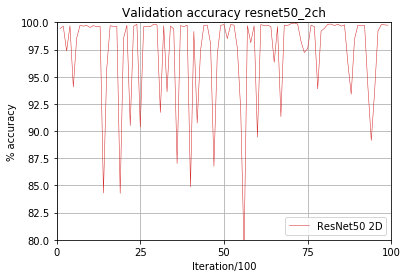

In [44]:
# num = len(resnet50_4D) # reduced rank by 1 for matrix math to work out
ymin = 80
ymax = 100
num = 100
x = np.arange(0,num,1) # Start at index position 1
plt.figure(figsize=(9, 6))
fig2 = plt.figure()
# plt.plot(x[1:num],resnet18_4D[1:num], c='#1f77b4',markersize=1, linewidth=.5,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=1,label='ResNet18 4D')
# plt.plot(x[1:num],resnet18_2D[1:num], c='#ff7f0e',markersize=1, linewidth=.5,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=1, label='ResNet18 2D')
# plt.plot(x[1:num],vgg16_4D[1:num], c='#2ca02c', markersize=1, linewidth=.5,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=1, label='VGG16 4D')
plt.plot(x[1:num],resnet50_2D[1:num], c='#d62728', markersize=1, linewidth=.5,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=1, label='ResNet50 2D')
# plt.plot(x[1:num],resnet50_4D[1:num], c='#9467bd', markersize=1, linewidth=.5,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=1, label='ResNet50 4D')
# plt.plot(x[1:num],vgg16_2D[1:num], c='#8c564b', markersize=1, linewidth=.5,markerfacecolor='#8c564b',markeredgecolor='#8c564b',markeredgewidth=2, label='VGG16 2D')
plt.legend(loc='lower right')
axes = plt.gca() # Get the Current Axis, create one, if necessary
xmin = 0
xmax = 100
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
#  '-o'   '-X' '-P' '-D' '-^' '-*'
plt.title('Validation accuracy resnet50_2ch')
plt.xlabel('Iteration/100')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(70,80,90,100.01))
plt.xticks([0, 25, 50, 75, 100])
fig2.savefig('resnet50_2ch.pdf', format="pdf")
plt.show()

In [ ]:
os.chdir(path_fig)
plt.figure(figsize=(9, 6))
fig = plt.figure()
plt.plot(loss_plot,c='r', label='Loss curve')
plt.legend(loc='upper right')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
fig.savefig('RF_class_v50_loss_4D.pdf', format="pdf")
plt.show()

### LIVE inferencing

In [138]:
# !python3 /home/david/sigMF_ML/gnuradio/record_live.py

#### 2D tensor with 300 noise
vodeson - 10
lora250 - 0
lora125 - 
click - 10
sado - 4ish
light - 
tyt - 
GD55
nfm - 


###  TESTING

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 25.000000 MHz... 
[INFO] [B200] Actually got clock rate 25.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
OOOinference file name =  test1.sigmf-meta
iq_read_test live
gpu_test live function
I length =  125000000
Q length =  125000000
gpu_test live IQ shape = torch.Size([25600, 9766, 2])
FINAL g

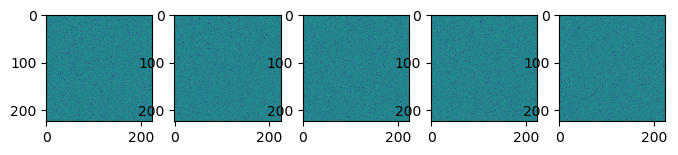

freq_increment =  219298.24561403508
TESTING inputs SHAPE =  torch.Size([1, 2451, 224, 224, 2])
input in   =  torch.Size([1, 2451, 224, 224, 2])
input out  =  torch.Size([2451, 224, 224, 2])
counter convert stuff =  tensor([2451]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([2451, 2, 224, 224])
mean Freq =    433.92
std Freq =      0.18
length of inputs =  2451


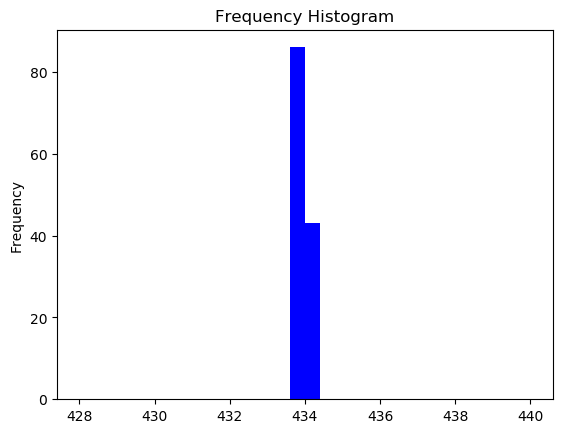

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 11.63%
TYT = 21.71
Vodeson Doorbell = 1.55%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 65.12%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2322
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************


In [158]:
msps = 25
center_freq_live = 428.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_25msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

In [ ]:
msps = 5
center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_5msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

In [141]:
msps = 1
center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live25msps.py
!python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
inference file name =  test1.sigmf-meta
iq_read_test live
gpu_test live function


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

## testing pre-recorded files in /home/david/sigMF_ML/RF/RF_class/testing_data

In [ ]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
testing_file(msps)
torch.cuda.empty_cache()

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
iq_read_test live
gpu_test live function
I length =  25000000
Q length =  25000000
5120 MSPS
gpu_test live IQ shape = torch.Size([5120, 9766, 2])
FINAL gpu_test LIVE IQ shape = torch.Size([2560, 9766, 2])
start_frequency =  433.0
sigmf_data =  (2560, 9766, 2)
frequency =  2560   time =  9766
seg_time =  43 seg_freq =  11
data_IQ shape =  (473, 224, 224, 2)
testing counter =  tensor([473]) seg_freq = tensor([11])
seg_freq =  tensor([11])
freq_increment =  227272.72727272726
TESTING inputs SHAPE =  torch.Size([1, 473, 224, 224, 2])
input in   =  torch.Size([1, 473, 224, 224, 2])
input out  =  torch.Size([473, 224, 224, 2])
counter convert stuff =  tensor([473]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([473, 2, 224, 224])
mean Freq =    433.80
std Freq =      0.80
length of inputs =  473


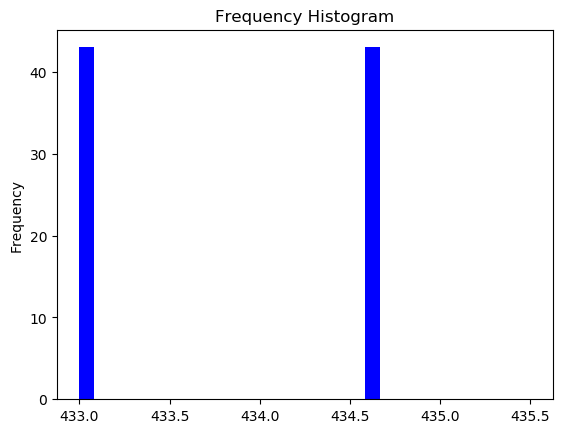

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 20.93%
NFM = 39.53%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 39.53%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  387
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************


In [54]:
msps = 5
center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps)
testing_file(msps)
torch.cuda.empty_cache()

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
iq_read_test live
gpu_test live function
I length =  10000000
Q length =  10000000
1024 MSPS
gpu_test live IQ shape = torch.Size([1024, 19532, 2])
FINAL gpu_test LIVE IQ shape = torch.Size([512, 19532, 2])
start_frequency =  433.65
sigmf_data =  (512, 19532, 2)
frequency =  512   time =  19532
seg_time =  87 seg_freq =  2
data_IQ shape =  (174, 224, 224, 2)
testing counter =  tensor([174]) seg_freq = tensor([2])
seg_freq =  tensor([2])
freq_increment =  250000.0
TESTING inputs SHAPE =  torch.Size([1, 174, 224, 224, 2])
input in   =  torch.Size([1, 174, 224, 224, 2])
input out  =  torch.Size([174, 224, 224, 2])
counter convert stuff =  tensor([174]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([174, 2, 224, 224])
mean Freq =    433.90
std Freq =      0.00
length of inputs =  174


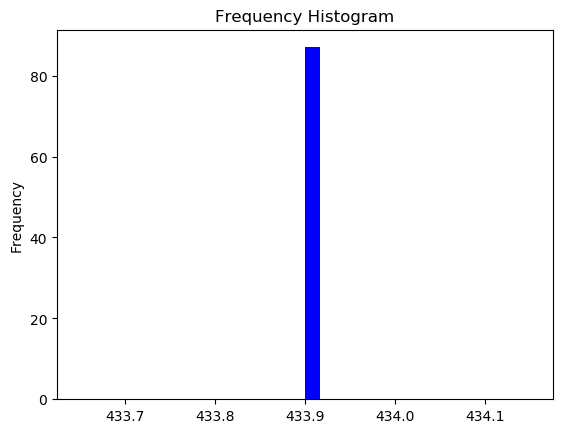

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 100.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************


In [51]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
testing_file(msps)
torch.cuda.empty_cache()

In [166]:
torch.cuda.empty_cache()

#### Save and Load model data

In [331]:
rf_model = 'ResNet50_v56_2D_20210208_100noise'

In [332]:
PATH = path_save+rf_model

#### save

In [333]:
# torch.save(model.state_dict(), PATH)

#### load

In [249]:
# device = torch.device("cuda:0")
# model = resnet50(2, 12)
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [45]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [46]:
# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [47]:
# # SAVE MODEL
# os.chdir(path_save)
# torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,
#            }, path_save+rf_model)

In [48]:
# # LOAD MODEL
# checkpoint = torch.load(path_save+rf_model, map_location=device)


# # STATUS
# checkpoint.keys()

# epoch = checkpoint['epoch']
# model_state_dict = checkpoint['model_state_dict']
# optimizer_state_dict = checkpoint['optimizer_state_dict']
# loss = checkpoint['loss']

# optimizer_state_dict.keys()

# optimizer_state_dict['param_groups']

# loss

# model.load_state_dict(model_state_dict)   

In [49]:
# loss

In [50]:
# optimizer_state_dict.keys()